# Solving Optimization Problems Computationally

In [1]:
%matplotlib inline
%load_ext rpy2.ipython

import os
import glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('notebook', font_scale=1.5)

In [2]:
import scipy.linalg as la
import scipy.optimize as opt

## 1. Curve fitting

Actual data from an ELISA experiment. The first column is log concentration, the second is the measured value from the ELISA assay at that concentration. Our task is to fit a 4 parameter logistic function to the observed data.

The 4 parameter logistic has the following form

$$
f(x) = \frac{A-D}{1+(x/C)^B}+ D
$$

where $A$, $B$, $C$ and $D$ are parameters to be determined.

### Inspect data

In [3]:
data = np.array(
    [[ 1.   ,  3.802],
     [ 2.   ,  3.802],
     [ 3.   ,  3.778],
     [ 4.   ,  3.718],
     [ 5.   ,  3.696],
     [ 6.   ,  3.181],
     [ 7.   ,  1.731],
     [ 8.   ,  0.744],
     [ 9.   ,  0.29 ],
     [10.   ,  0.124],
     [11.   ,  0.064],
     [12.   ,  0.05 ]]
)

In [4]:
x = data[:, 0]
y = data[:, 1]

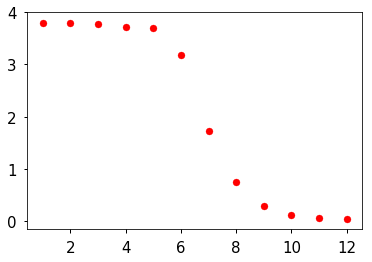

In [5]:
plt.scatter(x, y, c='red')
pass

### Define 4 parameter logistic

In [6]:
def f(x, A, B, C, D):
    return (A - D)/(1 + (x/C)**B)  + D

### Find reasonable values for initial parameters

In [7]:
A0 = y.max()
D0 = y.min()
C0 = x.mean()
B0 = 1
p0 = [A0, B0, C0, D0]

### Using `minimize` with conjugate-gradient

#### Define the loss function

In [8]:
def loss(p, y, x):
    A, B, C, D = p
    return np.sum((y - f(x, A, B, C, D))**2)

#### Minimize

In [9]:
r = opt.minimize(loss, p0, args=(y, x), method='CG')

In [10]:
r.x

array([ 3.78699634, 10.87666589,  6.91225087,  0.06131771])

#### Plot the fit

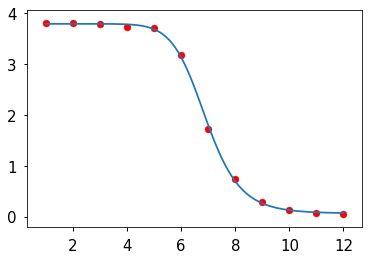

In [11]:
xp = np.linspace(x.min(), x.max(), 100)
plt.plot(xp, f(xp, *r.x))
plt.scatter(x, y, c='red')
pass

### Using nonlinear least squares

#### Define least squares residues

In [12]:
def res(p, y, x):
    A, B, C, D = p
    return (y - f(x, A, B, C, D))**2

#### Minimize

In [13]:
r = opt.least_squares(res, p0, args=(y, x))

In [14]:
r.x

array([ 3.7756568 , 11.02097427,  6.90573049,  0.07695251])

#### Plot

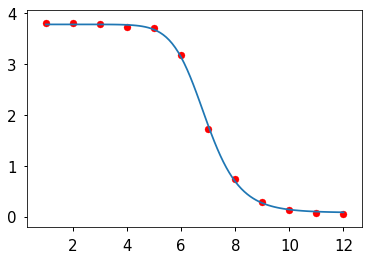

In [15]:
xp = np.linspace(x.min(), x.max(), 100)
plt.plot(xp, f(xp, *r.x))
plt.scatter(x, y, c='red')
pass

### Using `curve_fit`

This is the most convenient as you can work with the function directly. It uses the Levenberg-Marquadt algorithm.

#### Minimize

In [16]:
p, pcov = opt.curve_fit(f, x, y, p0)

In [17]:
p

array([ 3.78699349, 10.87690577,  6.91224723,  0.06132645])

#### Plot

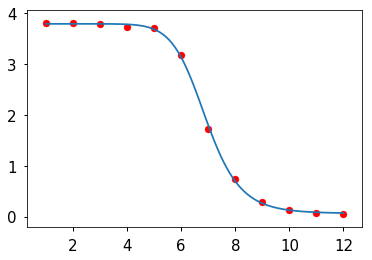

In [18]:
xp = np.linspace(x.min(), x.max(), 100)
plt.plot(xp, f(xp, *p))
plt.scatter(x, y, c='red')
pass

## 2. Constrained optimization

**A**. Using `scipy.optimize`, find the values of $x$ and $y$ that minimize $e^{x^2 + y^2}$ in the unconstrained case and in the presence of the constraint that $x + y = 3$. Use (1,1) as a starting guess.

In [19]:
opt.minimize(lambda x: np.exp(x[0]**2 + x[1]**2), 
            np.ones(2))

      fun: 1.0000000000000002
 hess_inv: array([[ 0.74999784, -0.25000216],
       [-0.25000216,  0.74999784]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 32
      nit: 7
     njev: 8
   status: 0
  success: True
        x: array([-8.0369005e-09, -8.0369005e-09])

In [20]:
opt.minimize(lambda x: np.exp(x[0]**2 + x[1]**2), 
             np.ones(2), 
             constraints=dict(type='eq', fun=lambda x: x[0] + x[1] - 3))

     fun: 90.01713130056051
     jac: array([270.05131435, 270.05148602])
 message: 'Optimization terminated successfully.'
    nfev: 44
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([1.49999954, 1.50000046])

**B**. A milkmaid is at point A and needs to get to point B. However, she also needs to fill a pail of water from the river en route from A to B. The equation of the river's path is shown in the figure below. What is the minimum distance she has to travel to do this?

![Milkmaid problem](data/milkmaid.png)

#### Define loss function

In [21]:
def f(x, A, B):
    return la.norm(x-A) + la.norm(x-B)

#### Define constraint

In [22]:
def g(x):
    return x[1] - 10.0/(1 + x[0])

#### Minimize

The solution is sensitive to the starting conditions.

In [23]:
x0 = np.array([4, 2])
A = np.array([2,8])
B = np.array([8,4])
cons = {'type': 'eq', 'fun': g}

res = opt.minimize(f, x0, args=(A, B), constraints=cons)
res.x, res.fun

(array([4.39881339, 1.85225887]), 10.792179122216428)

#### Plot

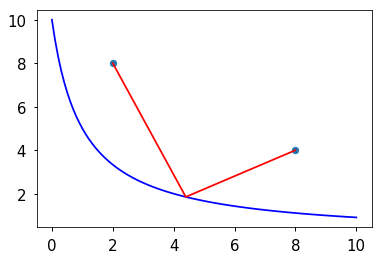

In [24]:
xp = np.linspace(0, 10, 100)
plt.scatter([A[0], B[0]], [A[1], B[1]])
plt.plot(xp, 10.0/(1 + xp), c='blue')
plt.plot([A[0], res.x[0], B[0]], [A[1], res.x[1], B[1]], c='red')
pass

#### Finding a better solution

We know that solutions must be along the river, so start with equally spaced points (in the x-direction) along the river.

In [25]:
x0s = [(x, 10/(1+x)) for x in range(11)]

In [26]:
best_x = None
best_fun = np.infty

A = np.array([2,8])
B = np.array([8,4])
cons = {'type': 'eq', 'fun': g}

for x0 in x0s:
    res = opt.minimize(f, x0, args=(A, B), constraints=cons)
    x, fun = res.x, res.fun
    if fun < best_fun:
        best_fun = fun
        best_x = x

In [27]:
best_x, best_fun

(array([0.53225961, 6.52630922]), 9.96339829956226)

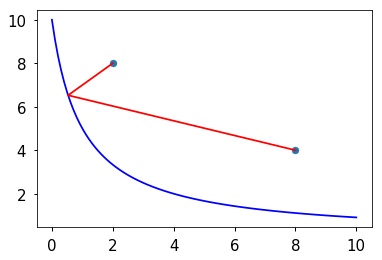

In [28]:
xp = np.linspace(0, 10, 100)
plt.scatter([A[0], B[0]], [A[1], B[1]])
plt.plot(xp, 10.0/(1 + xp), c='blue')
plt.plot([A[0], best_x[0], B[0]], [A[1], best_x[1], B[1]], c='red')
pass

**C**. Find the minimum of the following quadratic function on $\mathbb{R}^2$ 

$$f(x) = x^TAx +b^Tx +c$$
where
$$A = \left(\begin{matrix}13&5\\5&7\end{matrix}\right), b = \left(\begin{matrix}1\\1\end{matrix}\right) \textrm {and } c = 2$$

Under the constraints:
$$g(x) = 2x_1-5x_2=2 \;\;\;\;\;\; \textrm{ and } \;\;\;\;\;\; h(x) = x_1+x_2=1$$

1. Use a matrix decomposition method to find the minimum of the *unconstrained* problem without using `scipy.optimize` (Use library functions - no need to code your own). Note: for full credit you should exploit matrix structure. (3 points)
2. Find the solution using constrained optimization with the `scipy.optimize` package. (3 points)
2. Use Lagrange multipliers and solving the resulting set of equations directly without using `scipy.optimize`. (4 points)

In [29]:
A = np.array([[13,5],[5,7]])
b = np.array([1.0,1.0]).T
c = 2

la.cho_solve(la.cho_factor(A), -b/2)

array([-0.01515152, -0.06060606])

In [30]:
def f(x, A, b, c):
    return x.T.dot(A).dot(x) + b.T.dot(x) + c

# check unconstrained solution
usol = opt.minimize(f, [0,0], args=(A, b, c))
usol.x

array([-0.01515152, -0.06060606])

In [31]:
cons = ({'type': 'eq', 'fun': lambda x: 2*x[0] - 5*x[1] - 2},
        {'type': 'eq', 'fun': lambda x: x[0] + x[1] - 1})

opt.minimize(f, [0,0], constraints=cons, args=(A, b, c))

     fun: 15.999999999999996
     jac: array([26.99999976, 11.00000024])
 message: 'Optimization terminated successfully.'
    nfev: 14
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([1.00000000e+00, 3.41607086e-16])

In [32]:
M = np.array([
    [26, 10, 2, 1],
    [10, 14, -5, 1],
    [2, -5, 0, 0],
    [1, 1, 0, 0]
])

y = np.array([-1, -1, 2, 1]).T

la.solve(M, y)

array([ 1.00000000e+00, -4.37360585e-17, -2.28571429e+00, -2.24285714e+01])

## 3. Gradient descent

We observe some data points $(x_i, y_i)$, and believe that an appropriate model for the data is that

$$
f(x) = ax^2 + bx^3 + c\sin{x}
$$

with some added noise. Find optimal values of the parameters $\beta = (a, b, c)$ that minimize $\Vert y - f(x) \Vert^2$

1. using `scipy.linalg.lstsq` (10 points)
2. solving the normal equations $X^TX \beta = X^Ty$ (10 points)
3. using `scipy.linalg.svd` (10 points)
4. using gradient descent with RMSProp (no bias correction) and starting with an initial value of $\beta = \begin{bmatrix}1 & 1 & 1\end{bmatrix}$. Use a learning rate of 0.01 and 10,000 iterations. This should take a few seconds to complete. (25 points)

In each case, plot the data and fitted curve using `matplotlib`.

Data
```
x = array([ 3.4027718 ,  4.29209002,  5.88176277,  6.3465969 ,  7.21397852,
        8.26972154, 10.27244608, 10.44703778, 10.79203455, 14.71146298])
y = array([ 25.54026428,  29.4558919 ,  58.50315846,  70.24957254,
        90.55155435, 100.56372833,  91.83189927,  90.41536733,
        90.43103028,  23.0719842 ])
```

In [33]:
x = np.array([ 3.4027718 ,  4.29209002,  5.88176277,  6.3465969 ,  7.21397852,
        8.26972154, 10.27244608, 10.44703778, 10.79203455, 14.71146298])
y = np.array([ 25.54026428,  29.4558919 ,  58.50315846,  70.24957254,
        90.55155435, 100.56372833,  91.83189927,  90.41536733,
        90.43103028,  23.0719842 ])

In [34]:
def f(beta, x):
    """Model function."""
    
    return beta[0]*x**2 + beta[1]*x**3 + beta[2]*np.sin(x)

In [35]:
X = np.c_[x**2, x**3, np.sin(x)]

### Least squares solution

In [36]:
beta = np.linalg.lstsq(X, y, rcond=None)[0]

In [37]:
beta

array([ 2.99259014, -0.19883227, 10.20024689])

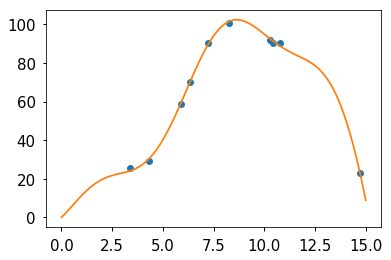

In [38]:
plt.plot(x, y, 'o')
xp = np.linspace(0, 15, 100)
plt.plot(xp, f(beta, xp))
pass

### Normal equations solution

In [39]:
beta = np.linalg.solve(X.T @ X, X.T @ y)
beta

array([ 2.99259014, -0.19883227, 10.20024689])

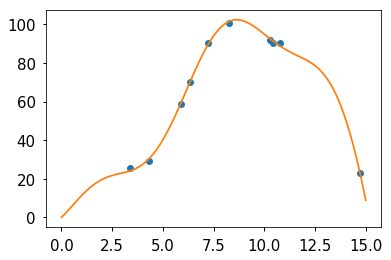

In [40]:
plt.plot(x, y, 'o')
xp = np.linspace(0, 15, 100)
plt.plot(xp, f(beta, xp))
pass

### SVD solution

In [41]:
U, s, Vt = np.linalg.svd(X)
beta = Vt.T @ np.diag(1/s) @ U[:, :len(s)].T @ y.reshape(-1,1)
beta

array([[ 2.99259014],
       [-0.19883227],
       [10.20024689]])

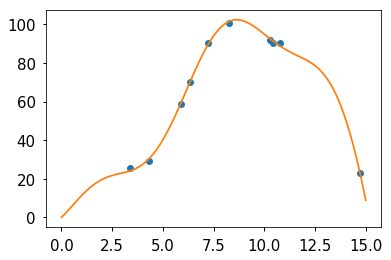

In [42]:
plt.plot(x, y, 'o')
xp = np.linspace(0, 15, 100)
plt.plot(xp, f(beta, xp))
pass

### Gradient descent solution (with ADAM)

In [43]:
def res(beta, x, y):
    """Resdiual funciton."""
    return f(beta, x) - y

In [44]:
def grad(beta, x, y):
    """Gradient of function."""
    
    return np.array([
        np.sum(x**2 * res(beta, x, y)),
        np.sum(x**3 * res(beta, x, y)),
        np.sum(np.sin(x) * res(beta, x, y))
    ])

In [45]:
def gd(beta, x, y, f, grad, alpha=0.01, beta1=0.9, beta2=0.999, eps=1e-8):
    """Gradient descent."""

    m = 0
    v = 0
    for i in range(10000):
        m = beta1*m + (1-beta1)*grad(beta, x, y)
        v = beta2*v + (1-beta2)*grad(beta, x, y)**2
        mc = m/(1+beta1**(i+1))
        vc = v/(1+beta2**(i+1))
        beta = beta - alpha * m / (eps + np.sqrt(vc))
    return beta

In [46]:
beta = gd(np.array([1,1,1]), x, y, f, grad)
beta

array([ 2.99259014, -0.19883227, 10.20024689])

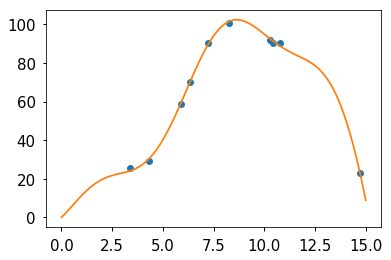

In [47]:
plt.plot(x, y, 'o')
xp = np.linspace(0, 15, 100)
plt.plot(xp, f(beta, xp))
pass